In [1]:
from google.colab import drive
drive.mount('/content/drive')

# mounting google drive files the dataset

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras._tf_keras.keras import layers, models

from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.applications import MobileNetV2
from keras._tf_keras.keras.layers import Dense, GlobalAveragePooling2D
from keras._tf_keras.keras.models import Model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# importing necessary libraries for the notebook

In [3]:
base_dir = '/content/drive/MyDrive/catdog/dataset'  # base directory
species = ['cats', 'dogs']   # Species classes

# defining directory from my google drive and classifying the folders

In [4]:
def detect_breeds(base_dir, species):
    breeds = {}
    for s in species:
        species_dir = os.path.join(base_dir, s)
        if os.path.exists(species_dir):
            breed_folders = [f for f in os.listdir(species_dir)
                           if os.path.isdir(os.path.join(species_dir, f))]
            breeds[s] = breed_folders
    return breeds

# Detecting breeds from folders to check how many breeds
breeds = detect_breeds(base_dir, species)
print(f"Detected breeds for cats: {breeds['cats']}")
print(f"Detected breeds for dogs: {breeds['dogs']}")

Detected breeds for cats: ['Bengal', 'Russian Blue', 'Persian', 'Birman', 'Abyssinian', 'British Shorthair', 'Maine Coon', 'Egyptian Mau', 'Bombay', 'Ragdoll', 'Siamese', 'Sphynx']
Detected breeds for dogs: ['basset hound', 'american bulldog', 'english cocker spaniel', 'chihuahua', 'beagle', 'english setter', 'german shorthaired', 'boxer', 'pomeranian', 'great pyrenees', 'newfoundland', 'shiba inu']


In [5]:
def create_label_mappings(species, breeds): # creating label mapping
    # Creating species mapping
    species_to_idx = {species[i]: i for i in range(len(species))}

    # Creating breed mapping (all breeds across all species)
    all_breeds = []
    for s in species:
        for b in breeds[s]:
            all_breeds.append(f"{s}_{b}")
    breed_to_idx = {all_breeds[i]: i for i in range(len(all_breeds))}

    # Creating reverse mappings for evaluation
    idx_to_species = {i: s for s, i in species_to_idx.items()}
    idx_to_breed = {i: b for b, i in breed_to_idx.items()}

    return species_to_idx, breed_to_idx, idx_to_species, idx_to_breed, all_breeds

species_to_idx, breed_to_idx, idx_to_species, idx_to_breed, all_breeds = create_label_mappings(species, breeds)
num_species = len(species)
num_breeds = len(breed_to_idx)

print(f"Number of species: {num_species}")
print(f"Number of total breed combinations: {num_breeds}")

Number of species: 2
Number of total breed combinations: 24


In [6]:
def prepare_dataset(base_dir, img_size=(224, 224)):
    # Creating lists for image paths and labels
    image_paths = []
    species_labels = []
    breed_labels = []

    for s in species:
        species_dir = os.path.join(base_dir, s)
        species_idx = species_to_idx[s]

        for b in breeds[s]:
            breed_dir = os.path.join(species_dir, b)
            breed_idx = breed_to_idx[f"{s}_{b}"]

            if os.path.exists(breed_dir):
                for img_name in os.listdir(breed_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(breed_dir, img_name)
                        image_paths.append(img_path)
                        species_labels.append(species_idx)
                        breed_labels.append(breed_idx)

    # Converting to numpy arrays
    image_paths = np.array(image_paths)
    species_labels = np.array(species_labels)
    breed_labels = np.array(breed_labels)

    # Counting samples per class
    breed_counts = {}
    for i, label in enumerate(breed_labels):
        breed_name = idx_to_breed[label]
        if breed_name not in breed_counts:
            breed_counts[breed_name] = 0
        breed_counts[breed_name] += 1

    print(f"Total images found: {len(image_paths)}")
    print(f"Images per breed: {breed_counts}")

    return image_paths, species_labels, breed_labels

image_paths, species_labels, breed_labels = prepare_dataset(base_dir)

Total images found: 4800
Images per breed: {'cats_Bengal': 200, 'cats_Russian Blue': 200, 'cats_Persian': 200, 'cats_Birman': 200, 'cats_Abyssinian': 200, 'cats_British Shorthair': 200, 'cats_Maine Coon': 200, 'cats_Egyptian Mau': 200, 'cats_Bombay': 200, 'cats_Ragdoll': 200, 'cats_Siamese': 200, 'cats_Sphynx': 200, 'dogs_basset hound': 200, 'dogs_american bulldog': 200, 'dogs_english cocker spaniel': 200, 'dogs_chihuahua': 200, 'dogs_beagle': 200, 'dogs_english setter': 200, 'dogs_german shorthaired': 200, 'dogs_boxer': 200, 'dogs_pomeranian': 200, 'dogs_great pyrenees': 200, 'dogs_newfoundland': 200, 'dogs_shiba inu': 200}


In [7]:
# spliting data into train/validation sets like train/test
def split_data(image_paths, species_labels, breed_labels, val_split=0.2):
    # Creating random indices
    indices = np.random.permutation(len(image_paths))
    train_size = int((1 - val_split) * len(indices))

    # spliting the data
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_paths = image_paths[train_indices]
    train_species = species_labels[train_indices]
    train_breeds = breed_labels[train_indices]

    val_paths = image_paths[val_indices]
    val_species = species_labels[val_indices]
    val_breeds = breed_labels[val_indices]

    print(f"Training set size: {len(train_paths)}")
    print(f"Validation set size: {len(val_paths)}")

    return (train_paths, train_species, train_breeds), (val_paths, val_species, val_breeds)

# spliting the data

train_data, val_data = split_data(image_paths, species_labels, breed_labels)
train_paths, train_species, train_breeds = train_data
val_paths, val_species, val_breeds = val_data

Training set size: 3840
Validation set size: 960


In [8]:
def create_data_generators(batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # validation data generator (just rescaling)
    val_datagen = ImageDataGenerator(rescale=1./255)

    def generate_batches(paths, species_labels, breed_labels, batch_size, datagen, img_size=(224, 224)):
        num_samples = len(paths)
        while True:
            indices = np.random.permutation(num_samples)
            for start_idx in range(0, num_samples, batch_size):
                batch_indices = indices[start_idx:min(start_idx + batch_size, num_samples)]
                batch_paths = paths[batch_indices]
                batch_species = species_labels[batch_indices]
                batch_breeds = breed_labels[batch_indices]

                # load and preprocess images
                batch_images = []
                for path in batch_paths:
                    try:
                        img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
                        img_array = tf.keras.preprocessing.image.img_to_array(img)
                        img_array = datagen.random_transform(img_array)
                        img_array = img_array / 255.0
                        batch_images.append(img_array)
                    except Exception as e:
                        print(f"Error loading image {path}: {e}")
                        continue

                if not batch_images:
                    continue  # skipping empty batches

                batch_images = np.array(batch_images)

                # one hot encode labels
                species_one_hot = tf.keras.utils.to_categorical(batch_species, num_species)
                breed_one_hot = tf.keras.utils.to_categorical(batch_breeds, num_breeds)

                yield batch_images, {'species_output': species_one_hot, 'breed_output': breed_one_hot}

    # creating the generators
    train_generator = generate_batches(train_paths, train_species, train_breeds, batch_size, train_datagen)
    val_generator = generate_batches(val_paths, val_species, val_breeds, batch_size, val_datagen)

    # measuring steps per epoch
    train_steps = len(train_paths) // batch_size
    val_steps = max(1, len(val_paths) // batch_size)

    return train_generator, val_generator, train_steps, val_steps

# data generators
batch_size = 32
train_generator, val_generator, train_steps, val_steps = create_data_generators(batch_size)

In [9]:
def build_model(input_shape=(224, 224, 3), num_species=2, num_breeds=24):
    # using transfer learning with MobileNetV2 as base model

    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # freezing the base model initially
    base_model.trainable = False

    # creating the model
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)

    shared_features = layers.Dense(512, activation='relu')(x)
    shared_features = layers.Dropout(0.3)(shared_features)

    # species classification head
    species_features = layers.Dense(256, activation='relu')(shared_features)
    species_output = layers.Dense(num_species, activation='softmax', name='species_output')(species_features)

    # breed classification head
    breed_features = layers.Dense(256, activation='relu')(shared_features)
    breed_output = layers.Dense(num_breeds, activation='softmax', name='breed_output')(breed_features)

    # creating the multi-output model
    model = models.Model(inputs=inputs, outputs=[species_output, breed_output])

    # compiling with appropriate loss weights
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'species_output': 'categorical_crossentropy',
            'breed_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'breed_output': 0.7
        },
        metrics={
            'species_output': 'accuracy',
            'breed_output': 'accuracy'
        }
    )

    return model, base_model

# building the model
model, base_model = build_model(num_species=num_species, num_breeds=num_breeds)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species_output      │ (None, 2)         │        514 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ breed_output        │ (None, 24)        │      6,168 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,183,194 (12.14 MB)

 Trainable params: 925,210 (3.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
def train_initial_phase(epochs=20):

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'catdog_model_phase1.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ), checkpoint]
    )

    return history

history_phase1 = train_initial_phase(epochs=20)

# training the model phase 1

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - breed_output_accuracy: 0.4898 - breed_output_loss: 1.7493 - loss: 1.2889 - species_output_accuracy: 0.9102 - species_output_loss: 0.2147 
Epoch 1: val_loss improved from inf to 0.35681, saving model to catdog_model_phase1.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 1614s 13s/step - breed_output_accuracy: 0.4910 - breed_output_loss: 1.7444 - loss: 1.2852 - species_output_accuracy: 0.9106 - species_output_loss: 0.2139 - val_breed_output_accuracy: 0.8333 - val_breed_output_loss: 0.4984 - val_loss: 0.3568 - val_species_output_accuracy: 0.9937 - val_species_output_loss: 0.0265
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - breed_output_accuracy: 0.8021 - breed_output_loss: 0.5698 - loss: 0.4198 - species_output_accuracy: 0.9733 - species_output_loss: 0.0698
Epoch 2: val_loss improved from 0.35681 to 0.30244, saving model to catdog_model_phase1.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 839ms/step - breed_output_accuracy: 0.8021 - breed_output_loss: 0.5698 - loss: 0.4198 - species_output_accuracy: 0.9733 - species_output_loss: 0.0697 - val_breed_output_accuracy: 0.8521 - val_breed_output_loss: 0.4168 - val_loss: 0.3024 - val_species_output_accuracy: 0.9906 - val_species_output_loss: 0.0356
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - breed_output_accuracy: 0.8339 - breed_output_loss: 0.5018 - loss: 0.3724 - species_output_accuracy: 0.9790 - species_output_loss: 0.0703
Epoch 3: val_loss did not improve from 0.30244
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 685ms/step - breed_output_accuracy: 0.8339 - breed_output_loss: 0.5017 - loss: 0.3723 - species_output_accuracy: 0.9790 - species_output_loss: 0.0702 - val_breed_output_accuracy: 0.8458 - val_breed_output_loss: 0.4270 - val_loss: 0.3060 - val_species_output_accuracy: 0.9906 - val_species_output_loss: 0.0236
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - breed_output_accura

120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 686ms/step - breed_output_accuracy: 0.8499 - breed_output_loss: 0.4582 - loss: 0.3367 - species_output_accuracy: 0.9807 - species_output_loss: 0.0533 - val_breed_output_accuracy: 0.8646 - val_breed_output_loss: 0.3927 - val_loss: 0.2845 - val_species_output_accuracy: 0.9896 - val_species_output_loss: 0.0320
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - breed_output_accuracy: 0.8598 - breed_output_loss: 0.4093 - loss: 0.2997 - species_output_accuracy: 0.9854 - species_output_loss: 0.0439
Epoch 5: val_loss improved from 0.28451 to 0.27692, saving model to catdog_model_phase1.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 64s 537ms/step - breed_output_accuracy: 0.8598 - breed_output_loss: 0.4094 - loss: 0.2997 - species_output_accuracy: 0.9854 - species_output_loss: 0.0439 - val_breed_output_accuracy: 0.8687 - val_breed_output_loss: 0.3851 - val_loss: 0.2769 - val_species_output_accuracy: 0.9896 - val_species_output_loss: 0.0245
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - breed_output_accuracy: 0.8597 - breed_output_loss: 0.3858 - loss: 0.2799 - species_output_accuracy: 0.9873 - species_output_loss: 0.0329
Epoch 6: val_loss did not improve from 0.27692
120/120 ━━━━━━━━━━━━━━━━━━━━ 80s 671ms/step - breed_output_accuracy: 0.8597 - breed_output_loss: 0.3860 - loss: 0.2801 - species_output_accuracy: 0.9873 - species_output_loss: 0.0329 - val_breed_output_accuracy: 0.8698 - val_breed_output_loss: 0.3912 - val_loss: 0.2818 - val_species_output_accuracy: 0.9885 - val_species_output_loss: 0.0266
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - breed_output_accurac

120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 569ms/step - breed_output_accuracy: 0.8749 - breed_output_loss: 0.3552 - loss: 0.2622 - species_output_accuracy: 0.9828 - species_output_loss: 0.0453 - val_breed_output_accuracy: 0.8729 - val_breed_output_loss: 0.3823 - val_loss: 0.2769 - val_species_output_accuracy: 0.9844 - val_species_output_loss: 0.0310
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - breed_output_accuracy: 0.8774 - breed_output_loss: 0.3617 - loss: 0.2603 - species_output_accuracy: 0.9903 - species_output_loss: 0.0237
Epoch 10: val_loss improved from 0.27692 to 0.25689, saving model to catdog_model_phase1.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 67s 566ms/step - breed_output_accuracy: 0.8773 - breed_output_loss: 0.3616 - loss: 0.2603 - species_output_accuracy: 0.9903 - species_output_loss: 0.0238 - val_breed_output_accuracy: 0.8792 - val_breed_output_loss: 0.3545 - val_loss: 0.2569 - val_species_output_accuracy: 0.9865 - val_species_output_loss: 0.0291
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - breed_output_accuracy: 0.8934 - breed_output_loss: 0.3088 - loss: 0.2290 - species_output_accuracy: 0.9862 - species_output_loss: 0.0429
Epoch 11: val_loss did not improve from 0.25689
120/120 ━━━━━━━━━━━━━━━━━━━━ 66s 553ms/step - breed_output_accuracy: 0.8934 - breed_output_loss: 0.3088 - loss: 0.2290 - species_output_accuracy: 0.9862 - species_output_loss: 0.0428 - val_breed_output_accuracy: 0.8792 - val_breed_output_loss: 0.3952 - val_loss: 0.2843 - val_species_output_accuracy: 0.9917 - val_species_output_loss: 0.0257
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - breed_output_accu

In [11]:
def train_fine_tuning_phase(epochs=30):
    base_model.trainable = True

    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lowwering learning rate
        loss={
            'species_output': 'categorical_crossentropy',
            'breed_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'breed_output': 0.7
        },
        metrics={
            'species_output': 'accuracy',
            'breed_output': 'accuracy'
        }
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[['accuracy'], ['accuracy']]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'catdog_model_final.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint]
    )

    return history

history_phase2 = train_fine_tuning_phase(epochs=30)

# training phase 2

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - breed_output_accuracy: 0.7919 - breed_output_loss: 0.6213 - loss: 0.4692 - species_output_accuracy: 0.9574 - species_output_loss: 0.1142
Epoch 1: val_loss improved from inf to 0.45328, saving model to catdog_model_final.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 616ms/step - breed_output_accuracy: 0.7923 - breed_output_loss: 0.6202 - loss: 0.4683 - species_output_accuracy: 0.9575 - species_output_loss: 0.1138 - val_breed_output_accuracy: 0.8271 - val_breed_output_loss: 0.6233 - val_loss: 0.4533 - val_species_output_accuracy: 0.9823 - val_species_output_loss: 0.0565
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - breed_output_accuracy: 0.8847 - breed_output_loss: 0.3128 - loss: 0.2336 - species_output_accuracy: 0.9792 - species_output_loss: 0.0487
Epoch 2: val_loss improved from 0.45328 to 0.42349, saving model to catdog_model_final.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 70s 584ms/step - breed_output_accuracy: 0.8847 - breed_output_loss: 0.3128 - loss: 0.2336 - species_output_accuracy: 0.9792 - species_output_loss: 0.0487 - val_breed_output_accuracy: 0.8490 - val_breed_output_loss: 0.5854 - val_loss: 0.4235 - val_species_output_accuracy: 0.9885 - val_species_output_loss: 0.0456
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - breed_output_accuracy: 0.9094 - breed_output_loss: 0.2767 - loss: 0.2034 - species_output_accuracy: 0.9894 - species_output_loss: 0.0325
Epoch 3: val_loss improved from 0.42349 to 0.35656, saving model to catdog_model_final.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 687ms/step - breed_output_accuracy: 0.9094 - breed_output_loss: 0.2768 - loss: 0.2035 - species_output_accuracy: 0.9894 - species_output_loss: 0.0325 - val_breed_output_accuracy: 0.8687 - val_breed_output_loss: 0.4857 - val_loss: 0.3566 - val_species_output_accuracy: 0.9865 - val_species_output_loss: 0.0553
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - breed_output_accuracy: 0.9244 - breed_output_loss: 0.2335 - loss: 0.1706 - species_output_accuracy: 0.9908 - species_output_loss: 0.0237
Epoch 4: val_loss did not improve from 0.35656
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 681ms/step - breed_output_accuracy: 0.9244 - breed_output_loss: 0.2335 - loss: 0.1705 - species_output_accuracy: 0.9908 - species_output_loss: 0.0237 - val_breed_output_accuracy: 0.8562 - val_breed_output_loss: 0.4951 - val_loss: 0.3576 - val_species_output_accuracy: 0.9896 - val_species_output_loss: 0.0365
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - breed_output_accurac

120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 689ms/step - breed_output_accuracy: 0.9324 - breed_output_loss: 0.1965 - loss: 0.1437 - species_output_accuracy: 0.9919 - species_output_loss: 0.0205 - val_breed_output_accuracy: 0.8573 - val_breed_output_loss: 0.4345 - val_loss: 0.3149 - val_species_output_accuracy: 0.9875 - val_species_output_loss: 0.0356
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - breed_output_accuracy: 0.9429 - breed_output_loss: 0.1662 - loss: 0.1213 - species_output_accuracy: 0.9948 - species_output_loss: 0.0164
Epoch 6: val_loss did not improve from 0.31485
120/120 ━━━━━━━━━━━━━━━━━━━━ 83s 694ms/step - breed_output_accuracy: 0.9429 - breed_output_loss: 0.1663 - loss: 0.1214 - species_output_accuracy: 0.9947 - species_output_loss: 0.0164 - val_breed_output_accuracy: 0.8687 - val_breed_output_loss: 0.4566 - val_loss: 0.3301 - val_species_output_accuracy: 0.9896 - val_species_output_loss: 0.0349
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - breed_output_accurac

120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - breed_output_accuracy: 0.9474 - breed_output_loss: 0.1582 - loss: 0.1167 - species_output_accuracy: 0.9917 - species_output_loss: 0.0200 - val_breed_output_accuracy: 0.8729 - val_breed_output_loss: 0.4215 - val_loss: 0.3055 - val_species_output_accuracy: 0.9875 - val_species_output_loss: 0.0348
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - breed_output_accuracy: 0.9463 - breed_output_loss: 0.1538 - loss: 0.1154 - species_output_accuracy: 0.9894 - species_output_loss: 0.0259
Epoch 8: val_loss improved from 0.30548 to 0.28852, saving model to catdog_model_final.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 689ms/step - breed_output_accuracy: 0.9463 - breed_output_loss: 0.1538 - loss: 0.1154 - species_output_accuracy: 0.9894 - species_output_loss: 0.0259 - val_breed_output_accuracy: 0.8760 - val_breed_output_loss: 0.4049 - val_loss: 0.2885 - val_species_output_accuracy: 0.9927 - val_species_output_loss: 0.0169
Epoch 9/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - breed_output_accuracy: 0.9530 - breed_output_loss: 0.1220 - loss: 0.0904 - species_output_accuracy: 0.9960 - species_output_loss: 0.0166
Epoch 9: val_loss did not improve from 0.28852
120/120 ━━━━━━━━━━━━━━━━━━━━ 78s 659ms/step - breed_output_accuracy: 0.9530 - breed_output_loss: 0.1220 - loss: 0.0904 - species_output_accuracy: 0.9960 - species_output_loss: 0.0166 - val_breed_output_accuracy: 0.8708 - val_breed_output_loss: 0.4504 - val_loss: 0.3240 - val_species_output_accuracy: 0.9896 - val_species_output_loss: 0.0292
Epoch 10/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - breed_output_accura

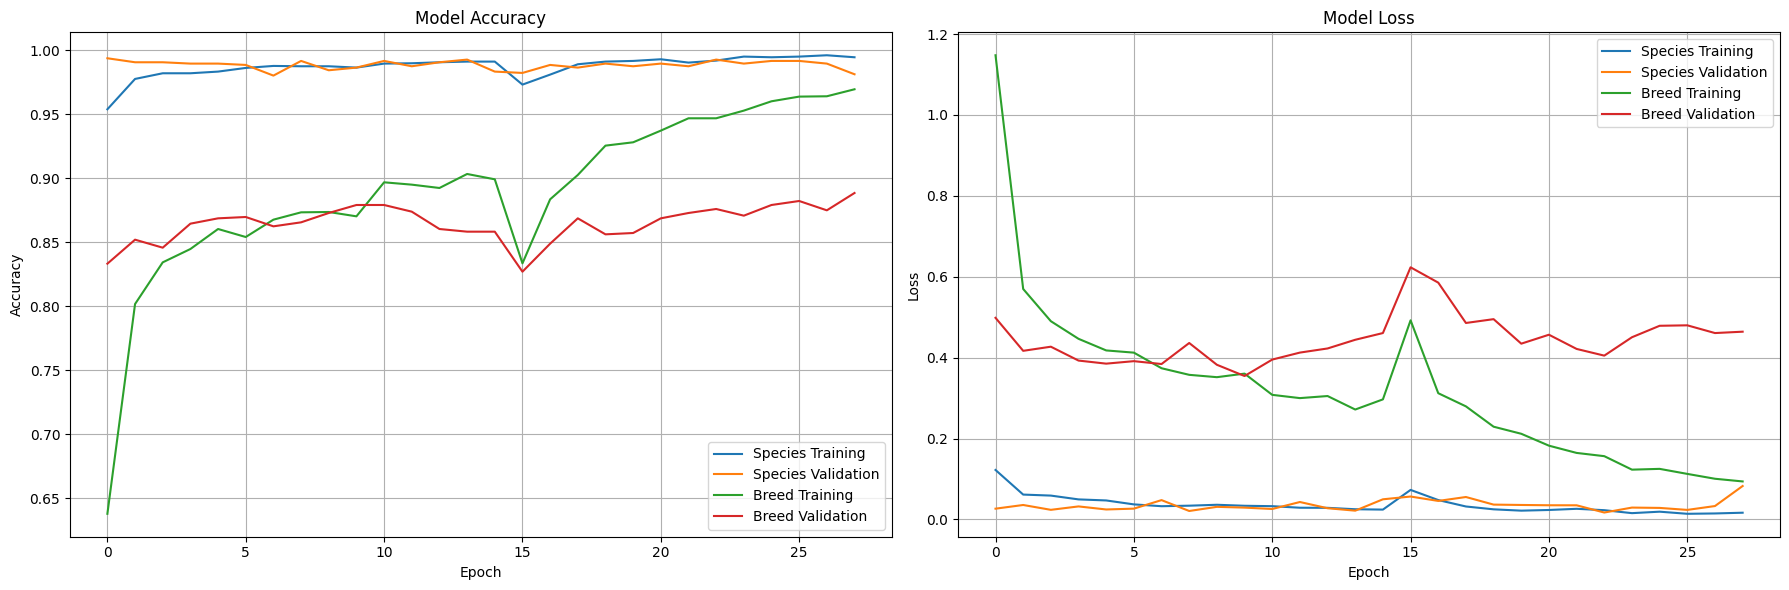

In [12]:
def plot_training_history(history1, history2=None):
    if history2:
        combined_history = {
            'species_output_accuracy': history1.history['species_output_accuracy'] + history2.history['species_output_accuracy'],
            'val_species_output_accuracy': history1.history['val_species_output_accuracy'] + history2.history['val_species_output_accuracy'],
            'breed_output_accuracy': history1.history['breed_output_accuracy'] + history2.history['breed_output_accuracy'],
            'val_breed_output_accuracy': history1.history['val_breed_output_accuracy'] + history2.history['val_breed_output_accuracy'],
            'species_output_loss': history1.history['species_output_loss'] + history2.history['species_output_loss'],
            'val_species_output_loss': history1.history['val_species_output_loss'] + history2.history['val_species_output_loss'],
            'breed_output_loss': history1.history['breed_output_loss'] + history2.history['breed_output_loss'],
            'val_breed_output_loss': history1.history['val_breed_output_loss'] + history2.history['val_breed_output_loss']
        }
    else:
        combined_history = history1.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(combined_history['species_output_accuracy'], label='Species Training')
    ax1.plot(combined_history['val_species_output_accuracy'], label='Species Validation')
    ax1.plot(combined_history['breed_output_accuracy'], label='Breed Training')
    ax1.plot(combined_history['val_breed_output_accuracy'], label='Breed Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(combined_history['species_output_loss'], label='Species Training')
    ax2.plot(combined_history['val_species_output_loss'], label='Species Validation')
    ax2.plot(combined_history['breed_output_loss'], label='Breed Training')
    ax2.plot(combined_history['val_breed_output_loss'], label='Breed Validation')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history_phase1, history_phase2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

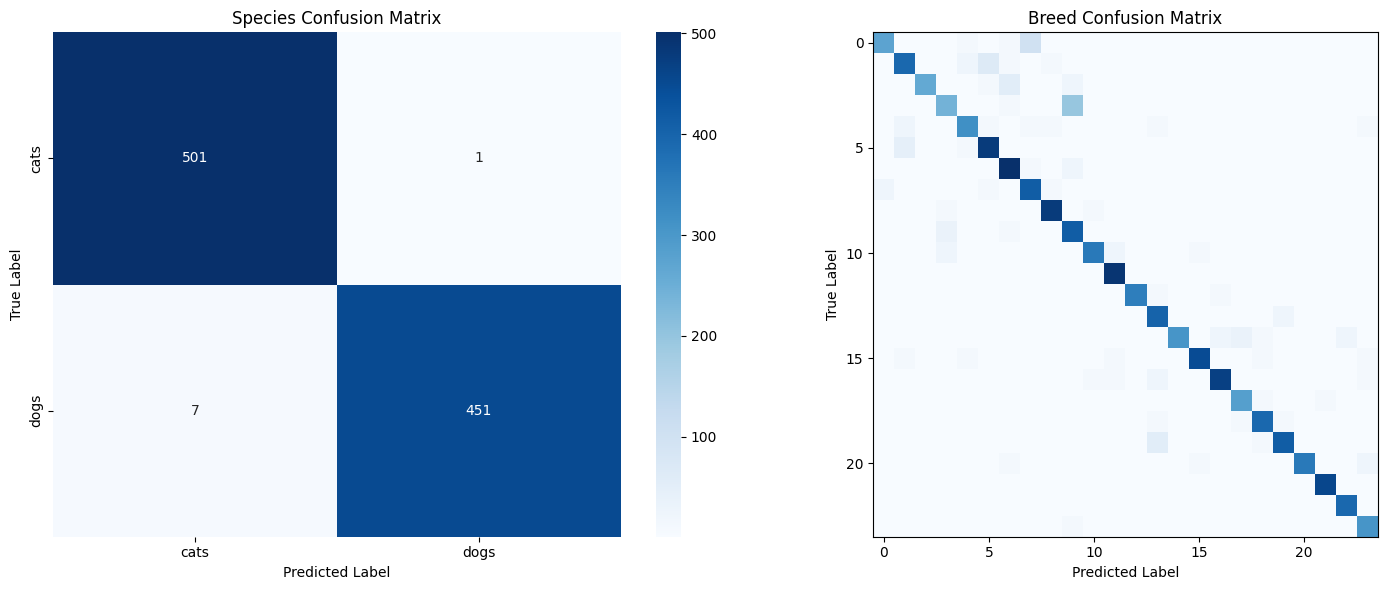

Species Classification Report:
              precision    recall  f1-score   support

        cats       0.99      1.00      0.99       502
        dogs       1.00      0.98      0.99       458

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960


Breed Classification Report Summary:
Breed Accuracy: 0.8792

Hierarchical Accuracy: 0.8771


In [13]:
def evaluate_model():
    batch_size = 32
    all_species_preds = []
    all_breed_preds = []

    for i in range(0, len(val_paths), batch_size):
        batch_paths = val_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                batch_images.append(img_array)
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                continue

        if not batch_images:
            continue

        batch_images = np.array(batch_images)

        predictions = model.predict(batch_images)
        species_pred_batch = np.argmax(predictions[0], axis=1)
        breed_pred_batch = np.argmax(predictions[1], axis=1)

        all_species_preds.extend(species_pred_batch)
        all_breed_preds.extend(breed_pred_batch)

    all_species_preds = np.array(all_species_preds[:len(val_species)])
    all_breed_preds = np.array(all_breed_preds[:len(val_breeds)])

    species_names = list(idx_to_species.values())
    breed_names = [b.split('_')[1] for b in list(idx_to_breed.values())]

    # this is confusion matrices
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    cm_species = confusion_matrix(val_species[:len(all_species_preds)], all_species_preds)
    sns.heatmap(cm_species, annot=True, fmt='d', cmap='Blues',
                xticklabels=species_names, yticklabels=species_names)
    plt.title('Species Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    cm_breeds = confusion_matrix(val_breeds[:len(all_breed_preds)], all_breed_preds)
    if len(breed_names) > 10:
        plt.imshow(cm_breeds, cmap='Blues')
        plt.title('Breed Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    else:
        sns.heatmap(cm_breeds, annot=True, fmt='d', cmap='Blues',
                    xticklabels=breed_names, yticklabels=breed_names)
        plt.title('Breed Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

    # classification reports
    print("Species Classification Report:")
    print(classification_report(val_species[:len(all_species_preds)], all_species_preds,
                               target_names=species_names))

    print("\nBreed Classification Report Summary:")
    breed_accuracy = np.mean(val_breeds[:len(all_breed_preds)] == all_breed_preds)
    print(f"Breed Accuracy: {breed_accuracy:.4f}")

    hierarchical_correct = (val_species[:len(all_species_preds)] == all_species_preds) & (val_breeds[:len(all_breed_preds)] == all_breed_preds)
    hierarchical_accuracy = np.mean(hierarchical_correct)
    print(f"\nHierarchical Accuracy: {hierarchical_accuracy:.4f}")

    return all_species_preds, all_breed_preds

species_predictions, breed_predictions = evaluate_model()

# evaluating the model

In [14]:
def save_model_and_mappings():
    save_dir = "/content/drive/MyDrive/catdog/models/"

    import os
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, 'pet_catdogclassifysavepoint.h5')
    model.save(model_path)

    import json
    mappings = {
        'species_to_idx': species_to_idx,
        'breed_to_idx': breed_to_idx,
        'idx_to_species': idx_to_species,
        'idx_to_breed': idx_to_breed
    }

    mappings_path = os.path.join(save_dir, 'label_mappings.json')
    with open(mappings_path, 'w') as f:
        mappings['idx_to_species'] = {str(k): v for k, v in mappings['idx_to_species'].items()}
        mappings['idx_to_breed'] = {str(k): v for k, v in mappings['idx_to_breed'].items()}
        json.dump(mappings, f)

    print(f"Model saved to: {model_path}")
    print(f"Mappings saved to: {mappings_path}")

save_model_and_mappings()

# saving the model on the google drive

Model saved to: /content/drive/MyDrive/catdog/models/pet_catdogclassifysavepoint.h5
Mappings saved to: /content/drive/MyDrive/catdog/models/label_mappings.json


In [15]:
def train_fine_tuning_phase(epochs=10):
    base_model.trainable = True

    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lowering learning rate again
        loss={
            'species_output': 'categorical_crossentropy',
            'breed_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'breed_output': 0.7
        },
        metrics={
            'species_output': 'accuracy',
            'breed_output': 'accuracy'
        }
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[['accuracy'], ['accuracy']]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'catdog_model_final1.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint]
    )

    return history

history_phase3 = train_fine_tuning_phase(epochs=10)

# phase 3

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - breed_output_accuracy: 0.9600 - breed_output_loss: 0.1238 - loss: 0.0931 - species_output_accuracy: 0.9922 - species_output_loss: 0.0216
Epoch 1: val_loss improved from inf to 0.34588, saving model to catdog_model_final1.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 628ms/step - breed_output_accuracy: 0.9600 - breed_output_loss: 0.1239 - loss: 0.0932 - species_output_accuracy: 0.9922 - species_output_loss: 0.0216 - val_breed_output_accuracy: 0.8729 - val_breed_output_loss: 0.4784 - val_loss: 0.3459 - val_species_output_accuracy: 0.9906 - val_species_output_loss: 0.0368
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - breed_output_accuracy: 0.9586 - breed_output_loss: 0.1258 - loss: 0.0935 - species_output_accuracy: 0.9932 - species_output_loss: 0.0182
Epoch 2: val_loss did not improve from 0.34588
120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 575ms/step - breed_output_accuracy: 0.9587 - breed_output_loss: 0.1258 - loss: 0.0935 - species_output_accuracy: 0.9932 - species_output_loss: 0.0181 - val_breed_output_accuracy: 0.8625 - val_breed_output_loss: 0.6260 - val_loss: 0.4565 - val_species_output_accuracy: 0.9865 - val_species_output_loss: 0.0610
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - breed_output_accurac

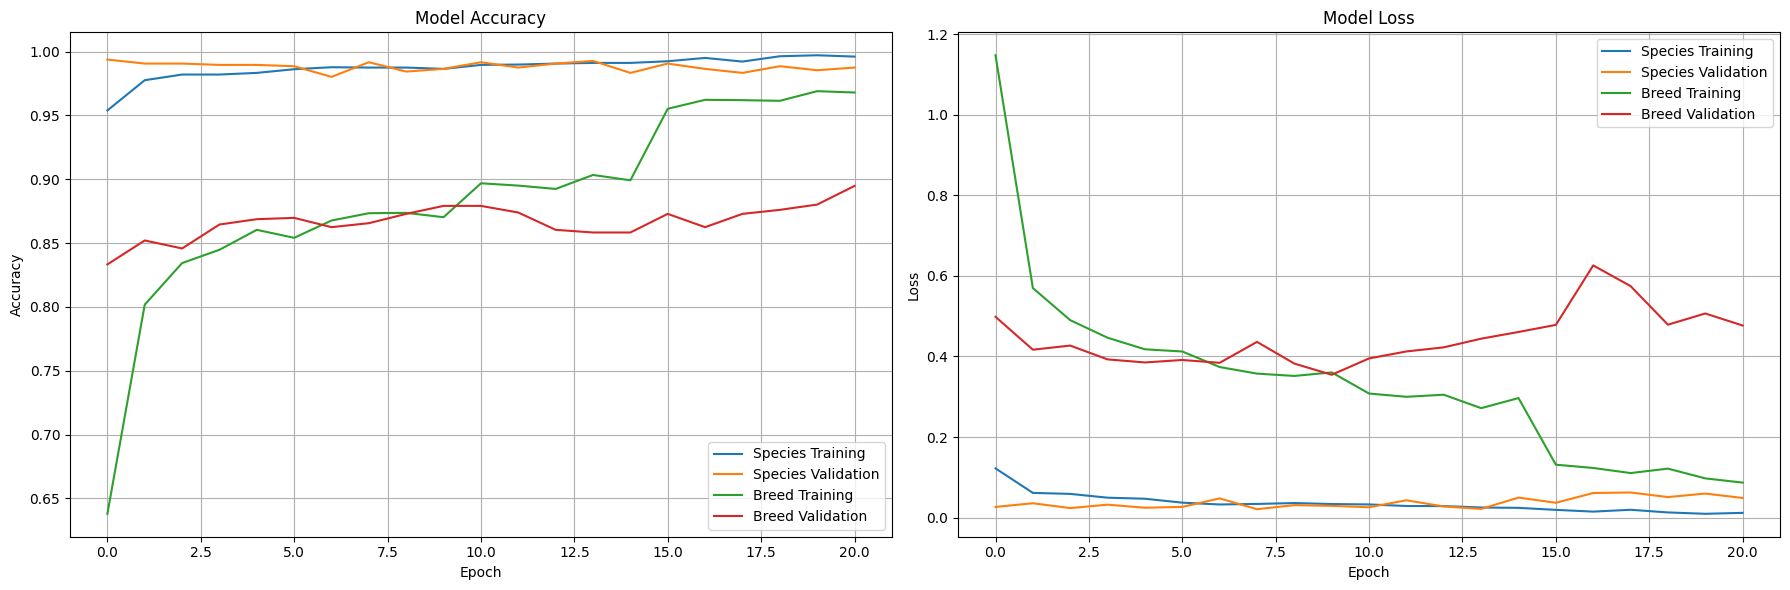

In [16]:
def plot_training_history(history1, history3=None):
    if history3:
        combined_history = {
            'species_output_accuracy': history1.history['species_output_accuracy'] + history3.history['species_output_accuracy'],
            'val_species_output_accuracy': history1.history['val_species_output_accuracy'] + history3.history['val_species_output_accuracy'],
            'breed_output_accuracy': history1.history['breed_output_accuracy'] + history3.history['breed_output_accuracy'],
            'val_breed_output_accuracy': history1.history['val_breed_output_accuracy'] + history3.history['val_breed_output_accuracy'],
            'species_output_loss': history1.history['species_output_loss'] + history3.history['species_output_loss'],
            'val_species_output_loss': history1.history['val_species_output_loss'] + history3.history['val_species_output_loss'],
            'breed_output_loss': history1.history['breed_output_loss'] + history3.history['breed_output_loss'],
            'val_breed_output_loss': history1.history['val_breed_output_loss'] + history3.history['val_breed_output_loss']
        }
    else:
        combined_history = history1.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(combined_history['species_output_accuracy'], label='Species Training')
    ax1.plot(combined_history['val_species_output_accuracy'], label='Species Validation')
    ax1.plot(combined_history['breed_output_accuracy'], label='Breed Training')
    ax1.plot(combined_history['val_breed_output_accuracy'], label='Breed Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(combined_history['species_output_loss'], label='Species Training')
    ax2.plot(combined_history['val_species_output_loss'], label='Species Validation')
    ax2.plot(combined_history['breed_output_loss'], label='Breed Training')
    ax2.plot(combined_history['val_breed_output_loss'], label='Breed Validation')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history_phase1, history_phase3)

In [17]:
def train_fine_tuning_phase(epochs=10):
    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lowering learning rate again
        loss={
            'species_output': 'categorical_crossentropy',
            'breed_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'breed_output': 0.7
        },
        metrics={
            'species_output': 'accuracy',
            'breed_output': 'accuracy'
        }
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        metrics=[['accuracy'], ['accuracy']]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'catdog_model_final2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint]
    )

    return history

history_phase4 = train_fine_tuning_phase(epochs=10)

# phase 4

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - breed_output_accuracy: 0.9597 - breed_output_loss: 0.1062 - loss: 0.0777 - species_output_accuracy: 0.9956 - species_output_loss: 0.0111
Epoch 1: val_loss improved from inf to 0.30197, saving model to catdog_model_final2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 615ms/step - breed_output_accuracy: 0.9598 - breed_output_loss: 0.1062 - loss: 0.0777 - species_output_accuracy: 0.9956 - species_output_loss: 0.0111 - val_breed_output_accuracy: 0.8833 - val_breed_output_loss: 0.4138 - val_loss: 0.3020 - val_species_output_accuracy: 0.9885 - val_species_output_loss: 0.0410
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - breed_output_accuracy: 0.9620 - breed_output_loss: 0.1181 - loss: 0.0879 - species_output_accuracy: 0.9937 - species_output_loss: 0.0173
Epoch 2: val_loss improved from 0.30197 to 0.29642, saving model to catdog_model_final2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 69s 583ms/step - breed_output_accuracy: 0.9620 - breed_output_loss: 0.1180 - loss: 0.0878 - species_output_accuracy: 0.9938 - species_output_loss: 0.0173 - val_breed_output_accuracy: 0.8896 - val_breed_output_loss: 0.4136 - val_loss: 0.2964 - val_species_output_accuracy: 0.9937 - val_species_output_loss: 0.0230
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - breed_output_accuracy: 0.9680 - breed_output_loss: 0.0960 - loss: 0.0703 - species_output_accuracy: 0.9957 - species_output_loss: 0.0105
Epoch 3: val_loss improved from 0.29642 to 0.28052, saving model to catdog_model_final2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 679ms/step - breed_output_accuracy: 0.9680 - breed_output_loss: 0.0959 - loss: 0.0703 - species_output_accuracy: 0.9957 - species_output_loss: 0.0105 - val_breed_output_accuracy: 0.8958 - val_breed_output_loss: 0.3913 - val_loss: 0.2805 - val_species_output_accuracy: 0.9948 - val_species_output_loss: 0.0221
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - breed_output_accuracy: 0.9730 - breed_output_loss: 0.0814 - loss: 0.0592 - species_output_accuracy: 0.9977 - species_output_loss: 0.0073
Epoch 4: val_loss improved from 0.28052 to 0.25394, saving model to catdog_model_final2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 572ms/step - breed_output_accuracy: 0.9730 - breed_output_loss: 0.0814 - loss: 0.0592 - species_output_accuracy: 0.9977 - species_output_loss: 0.0074 - val_breed_output_accuracy: 0.9000 - val_breed_output_loss: 0.3530 - val_loss: 0.2539 - val_species_output_accuracy: 0.9958 - val_species_output_loss: 0.0228
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - breed_output_accuracy: 0.9785 - breed_output_loss: 0.0841 - loss: 0.0632 - species_output_accuracy: 0.9955 - species_output_loss: 0.0143
Epoch 5: val_loss did not improve from 0.25394
120/120 ━━━━━━━━━━━━━━━━━━━━ 67s 558ms/step - breed_output_accuracy: 0.9784 - breed_output_loss: 0.0842 - loss: 0.0632 - species_output_accuracy: 0.9955 - species_output_loss: 0.0143 - val_breed_output_accuracy: 0.8969 - val_breed_output_loss: 0.3904 - val_loss: 0.2810 - val_species_output_accuracy: 0.9917 - val_species_output_loss: 0.0258
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - breed_output_accurac

In [18]:
def train_fine_tuning_phase(epochs=5):
    base_model.trainable = True

    for layer in base_model.layers[:100]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # lowering learning rate again
        loss={
            'species_output': 'categorical_crossentropy',
            'breed_output': 'categorical_crossentropy'
        },
        loss_weights={
            'species_output': 0.3,
            'breed_output': 0.7
        },
        metrics={
            'species_output': 'accuracy',
            'breed_output': 'accuracy'
        }
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[['accuracy'], ['accuracy']]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'catdog_model_final3.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint]
    )

    return history

history_phase5 = train_fine_tuning_phase(epochs=5)

# phase 5

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - breed_output_accuracy: 0.9582 - breed_output_loss: 0.1236 - loss: 0.0956 - species_output_accuracy: 0.9886 - species_output_loss: 0.0302
Epoch 1: val_loss improved from inf to 0.37769, saving model to catdog_model_final3.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 639ms/step - breed_output_accuracy: 0.9582 - breed_output_loss: 0.1236 - loss: 0.0955 - species_output_accuracy: 0.9887 - species_output_loss: 0.0301 - val_breed_output_accuracy: 0.8792 - val_breed_output_loss: 0.5049 - val_loss: 0.3777 - val_species_output_accuracy: 0.9844 - val_species_output_loss: 0.0809
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - breed_output_accuracy: 0.9547 - breed_output_loss: 0.1326 - loss: 0.0968 - species_output_accuracy: 0.9945 - species_output_loss: 0.0133
Epoch 2: val_loss improved from 0.37769 to 0.30289, saving model to catdog_model_final3.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 80s 670ms/step - breed_output_accuracy: 0.9547 - breed_output_loss: 0.1325 - loss: 0.0968 - species_output_accuracy: 0.9946 - species_output_loss: 0.0133 - val_breed_output_accuracy: 0.9021 - val_breed_output_loss: 0.4109 - val_loss: 0.3029 - val_species_output_accuracy: 0.9906 - val_species_output_loss: 0.0509
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - breed_output_accuracy: 0.9639 - breed_output_loss: 0.1130 - loss: 0.0824 - species_output_accuracy: 0.9967 - species_output_loss: 0.0111
Epoch 3: val_loss did not improve from 0.30289
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 677ms/step - breed_output_accuracy: 0.9639 - breed_output_loss: 0.1129 - loss: 0.0824 - species_output_accuracy: 0.9967 - species_output_loss: 0.0111 - val_breed_output_accuracy: 0.8875 - val_breed_output_loss: 0.4479 - val_loss: 0.3374 - val_species_output_accuracy: 0.9833 - val_species_output_loss: 0.0796
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - breed_output_accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

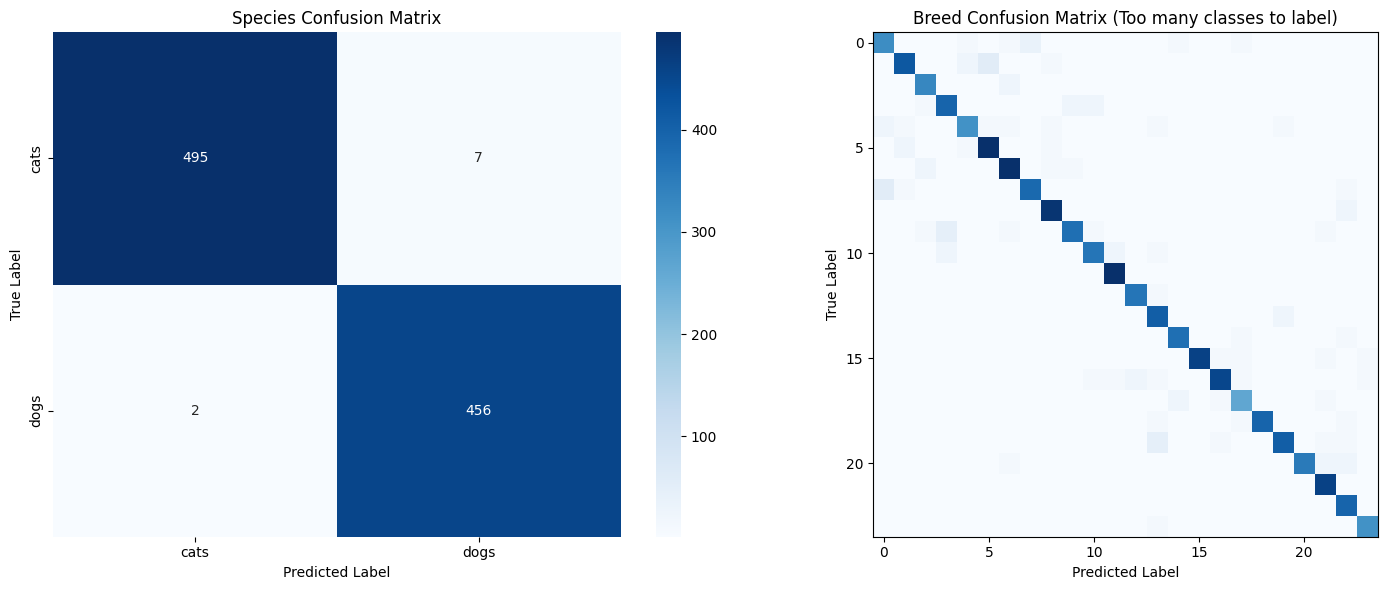

Species Classification Report:
              precision    recall  f1-score   support

        cats       1.00      0.99      0.99       502
        dogs       0.98      1.00      0.99       458

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960


Breed Classification Report Summary:
Breed Accuracy: 0.9000

Hierarchical Accuracy: 0.8979


In [19]:
def evaluate_model():
    batch_size = 32
    all_species_preds = []
    all_breed_preds = []

    for i in range(0, len(val_paths), batch_size):
        batch_paths = val_paths[i:i + batch_size]
        batch_images = []

        for path in batch_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                batch_images.append(img_array)
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                continue

        if not batch_images:
            continue

        batch_images = np.array(batch_images)

        predictions = model.predict(batch_images)
        species_pred_batch = np.argmax(predictions[0], axis=1)
        breed_pred_batch = np.argmax(predictions[1], axis=1)

        all_species_preds.extend(species_pred_batch)
        all_breed_preds.extend(breed_pred_batch)

    all_species_preds = np.array(all_species_preds[:len(val_species)])
    all_breed_preds = np.array(all_breed_preds[:len(val_breeds)])

    species_names = list(idx_to_species.values())
    breed_names = [b.split('_')[1] for b in list(idx_to_breed.values())]

    # confusion matrices
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    cm_species = confusion_matrix(val_species[:len(all_species_preds)], all_species_preds)
    sns.heatmap(cm_species, annot=True, fmt='d', cmap='Blues',
                xticklabels=species_names, yticklabels=species_names)
    plt.title('Species Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    cm_breeds = confusion_matrix(val_breeds[:len(all_breed_preds)], all_breed_preds)
    if len(breed_names) > 10:
        plt.imshow(cm_breeds, cmap='Blues')
        plt.title('Breed Confusion Matrix (Too many classes to label)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    else:
        sns.heatmap(cm_breeds, annot=True, fmt='d', cmap='Blues',
                    xticklabels=breed_names, yticklabels=breed_names)
        plt.title('Breed Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

    # classification reports
    print("Species Classification Report:")
    print(classification_report(val_species[:len(all_species_preds)], all_species_preds,
                               target_names=species_names))

    print("\nBreed Classification Report Summary:")
    breed_accuracy = np.mean(val_breeds[:len(all_breed_preds)] == all_breed_preds)
    print(f"Breed Accuracy: {breed_accuracy:.4f}")

    hierarchical_correct = (val_species[:len(all_species_preds)] == all_species_preds) & (val_breeds[:len(all_breed_preds)] == all_breed_preds)
    hierarchical_accuracy = np.mean(hierarchical_correct)
    print(f"\nHierarchical Accuracy: {hierarchical_accuracy:.4f}")

    return all_species_preds, all_breed_preds

species_predictions, breed_predictions = evaluate_model()

In [20]:
def save_model_and_mappings():
    save_dir = "/content/drive/MyDrive/catdog/models/"

    import os
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, 'petspecies_catdogclassify.h5')
    model.save(model_path)

    import json
    mappings = {
        'species_to_idx': species_to_idx,
        'breed_to_idx': breed_to_idx,
        'idx_to_species': idx_to_species,
        'idx_to_breed': idx_to_breed
    }

    mappings_path = os.path.join(save_dir, 'label_mappings.json')
    with open(mappings_path, 'w') as f:
        mappings['idx_to_species'] = {str(k): v for k, v in mappings['idx_to_species'].items()}
        mappings['idx_to_breed'] = {str(k): v for k, v in mappings['idx_to_breed'].items()}
        json.dump(mappings, f)

    print(f"Model saved to: {model_path}")
    print(f"Mappings saved to: {mappings_path}")

save_model_and_mappings()

# saving the model on the google drive

Model saved to: /content/drive/MyDrive/catdog/models/petspecies_catdogclassify.h5
Mappings saved to: /content/drive/MyDrive/catdog/models/label_mappings.json


In [31]:
def visualize_predictions(num_samples=6):
    # selecting random samples from validation set
    if len(val_paths) >= num_samples:
        indices = np.random.choice(len(val_paths), num_samples, replace=False)

        # creating a grid of images with their predictions
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            path = val_paths[idx]
            true_species = idx_to_species[val_species[idx]]
            true_breed_full = idx_to_breed[val_breeds[idx]]
            true_breed = true_breed_full.split('_')[1]

            # predicting
            img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            predictions = model.predict(img_array)
            pred_species_idx = np.argmax(predictions[0][0])
            pred_breed_idx = np.argmax(predictions[1][0])

            pred_species = idx_to_species[pred_species_idx]
            pred_breed_full = idx_to_breed[pred_breed_idx]
            pred_breed = pred_breed_full.split('_')[1]

            # getting confidence scores
            species_conf = predictions[0][0][pred_species_idx] * 100
            breed_conf = predictions[1][0][pred_breed_idx] * 100

            # displaying on the grid
            axes[i].imshow(img)

            # setting color based on correctness
            species_color = 'green' if true_species == pred_species else 'red'
            breed_color = 'green' if true_breed == pred_breed else 'red'

            axes[i].set_title(f"True: {true_species}, {true_breed}\n" +
                            f"Pred: {pred_species}, {pred_breed}\n" +
                            f"Conf: Sp {species_conf:.0f}%, Br {breed_conf:.0f}%",
                            color='black')

            # adding colored borders for quick visual feedback on correctness
            border_color = 'green' if (true_species == pred_species and true_breed == pred_breed) else 'red'
            for spine in axes[i].spines.values():
                spine.set_color(border_color)
                spine.set_linewidth(5)

            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig('prediction_examples.png')
        plt.show()
    else:
        print("Not enough validation images available for visualization")

# visualizing predictions on sample images
visualize_predictions(num_samples=6)

Output hidden; open in https://colab.research.google.com to view.